# Alignement par paire:

In [2]:
import csv
import time
import random
import numpy as np
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Visualiser la matrice BLOSUM62 pour l'utiliser dans le code

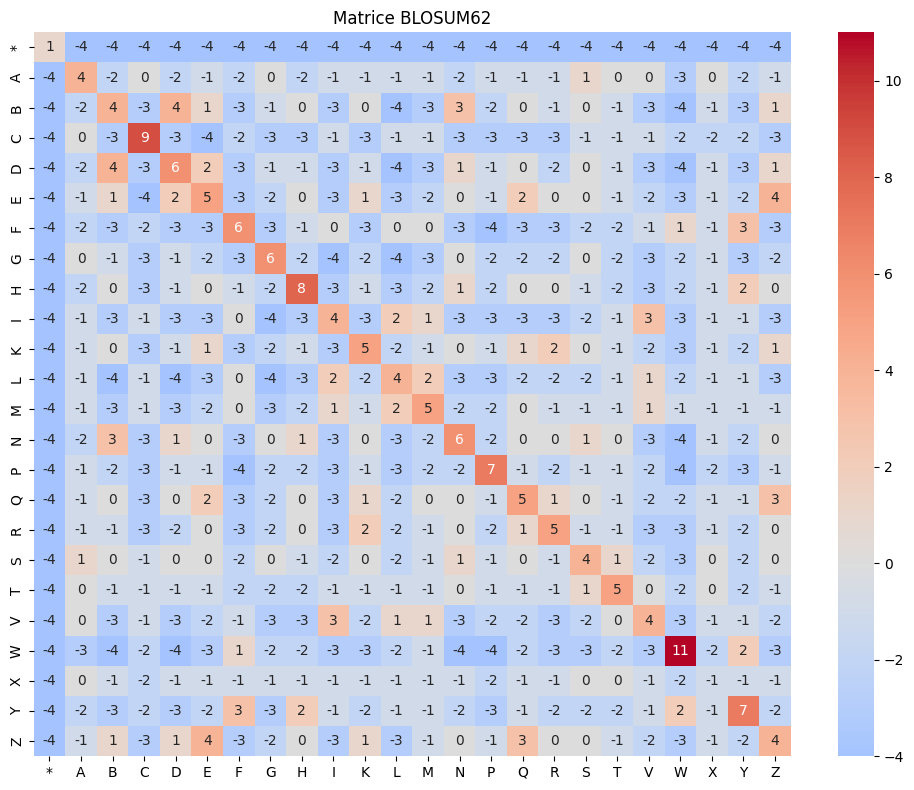

In [ ]:
def load_blosum62():
    """Charge la matrice BLOSUM62 depuis Biopython."""
    blosum = substitution_matrices.load("BLOSUM62")
    return {(a, b): blosum[a, b] for a, b in blosum.keys()}

# Charger la matrice
blosum_dict = load_blosum62()

# Extraire les acides aminés utilisés
amino_acids = sorted(list(set([key[0] for key in blosum_dict.keys()])))

# Créer une DataFrame pour visualiser la matrice
data = []
for aa1 in amino_acids:
    row = []
    for aa2 in amino_acids:
        row.append(blosum_dict.get((aa1, aa2), 0))
    data.append(row)

df = pd.DataFrame(data, index=amino_acids, columns=amino_acids)

# Plot avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice BLOSUM62")
plt.tight_layout()
plt.savefig("blosum62_matrix.png")
plt.show()


In [5]:
# Matrice BLOSUM62 simplifiée (remplacez-la ou chargez-en une vraie si besoin)
BLOSUM62 = load_blosum62()

def score(matrix, a, b, default=-1):
    """
    Fonction de score générique : retourne le score entre deux caractères
    en consultant la matrice de similarité fournie.

    Paramètres :
    - matrix : dictionnaire contenant les scores (ex : BLOSUM62)
    - a, b : caractères à comparer
    - default : valeur par défaut si la paire n’est pas trouvée

    Retourne :
    - le score associé à la paire (a, b)
    """
    return matrix.get((a, b)) or matrix.get((b, a), default)

def needleman_wunsch(seq1, seq2, matrix, gap_penalty=-2):
    """
    Algorithme de Needleman-Wunsch : alignement global entre deux séquences.

    Paramètres :
    - seq1, seq2 : les deux séquences à aligner (chaînes de caractères)
    - matrix : matrice de similarité sous forme de dictionnaire
    - gap_penalty : pénalité pour l’introduction d’un gap (valeur négative)

    Retourne :
    - score de l’alignement optimal
    - les deux séquences alignées avec gaps éventuels
    """
    # Récupérer les longueurs des deux séquences
    n, m = len(seq1), len(seq2)

    # Initialiser la matrice des scores (remplie de zéros au départ)
    score_matrix = np.zeros((n + 1, m + 1), dtype=int)

    # Matrice de traceback : indique le chemin suivi pour reconstruire l'alignement
    traceback = np.zeros((n + 1, m + 1), dtype=str)

    # Initialisation de la première ligne (insertion de gaps dans seq2)
    for i in range(1, n + 1):
        score_matrix[i][0] = i * gap_penalty
        traceback[i][0] = 'U'  # "Up" : on vient de la case du dessus

    # Initialisation de la première colonne (insertion de gaps dans seq1)
    for j in range(1, m + 1):
        score_matrix[0][j] = j * gap_penalty
        traceback[0][j] = 'L'  # "Left" : on vient de la case de gauche

    # Remplissage de la matrice de score
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Calculer les 3 scores possibles
            match = score_matrix[i - 1][j - 1] + score(matrix, seq1[i - 1], seq2[j - 1])
            delete = score_matrix[i - 1][j] + gap_penalty  # gap dans seq2
            insert = score_matrix[i][j - 1] + gap_penalty  # gap dans seq1

            # Choisir le meilleur score
            max_score = max(match, delete, insert)
            score_matrix[i][j] = max_score

            # Enregistrer la direction d’où provient ce score
            if max_score == match:
                traceback[i][j] = 'D'  # "Diagonal"
            elif max_score == delete:
                traceback[i][j] = 'U'  # "Up"
            else:
                traceback[i][j] = 'L'  # "Left"

    # Reconstruction de l'alignement optimal (backtracking)
    aligned_seq1 = ""
    aligned_seq2 = ""
    i, j = n, m  # on commence en bas à droite

    while i > 0 or j > 0:
        move = traceback[i][j]
        if i == 0:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            j -= 1
        elif j == 0:
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            if move == 'D':
                aligned_seq1 = seq1[i - 1] + aligned_seq1
                aligned_seq2 = seq2[j - 1] + aligned_seq2
                i -= 1
                j -= 1
            elif move == 'U':
                aligned_seq1 = seq1[i - 1] + aligned_seq1
                aligned_seq2 = '-' + aligned_seq2
                i -= 1
            elif move == 'L':
                aligned_seq1 = '-' + aligned_seq1
                aligned_seq2 = seq2[j - 1] + aligned_seq2
                j -= 1
            else:
                break  # sécurité (normalement inutile ici)

    return score_matrix[n][m], aligned_seq1, aligned_seq2

def smith_waterman(seq1, seq2, matrix, gap_penalty=-2):
    """
    Algorithme de Smith-Waterman : alignement local de deux séquences.

    Paramètres :
    - seq1, seq2 : chaînes de caractères représentant les séquences
    - matrix : matrice de similarité (ex : BLOSUM62)
    - gap_penalty : pénalité pour l’introduction d’un gap

    Retourne :
    - score de l’alignement local optimal
    - les deux sous-séquences alignées
    """
    n, m = len(seq1), len(seq2)

    # Initialisation des matrices : score et traceback
    score_matrix = np.zeros((n + 1, m + 1), dtype=int)
    traceback = np.zeros((n + 1, m + 1), dtype=str)

    max_score = 0           # Score maximal trouvé dans la matrice
    max_pos = (0, 0)        # Position de ce score maximal (i, j)

    # Remplissage de la matrice de score
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Calcul des scores potentiels
            match = score_matrix[i - 1][j - 1] + score(matrix, seq1[i - 1], seq2[j - 1])
            delete = score_matrix[i - 1][j] + gap_penalty
            insert = score_matrix[i][j - 1] + gap_penalty

            # Le score local ne peut pas être négatif : max avec 0
            current_score = max(0, match, delete, insert)
            score_matrix[i][j] = current_score

            # Mise à jour de la matrice de traceback
            if current_score == 0:
                traceback[i][j] = '0'  # début d’un nouvel alignement local
            elif current_score == match:
                traceback[i][j] = 'D'  # Diagonale
            elif current_score == delete:
                traceback[i][j] = 'U'  # Haut
            else:
                traceback[i][j] = 'L'  # Gauche

            # Mise à jour du meilleur score global
            if current_score > max_score:
                max_score = current_score
                max_pos = (i, j)

    # Reconstruction de l'alignement local optimal (backtracking)
    aligned_seq1 = ""
    aligned_seq2 = ""
    i, j = max_pos

    while i > 0 and j > 0 and traceback[i][j] != '0':
        move = traceback[i][j]
        if move == 'D':
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif move == 'U':
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        elif move == 'L':
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1

    return max_score, aligned_seq1, aligned_seq2

In [10]:

seq1, seq2 = "FATCATY", "TCAGSFA"
# Alignement local
score_sw, aln1_sw, aln2_sw = smith_waterman(seq1, seq2, BLOSUM62, gap_penalty=-6)
print("\n[LOCAL] Smith-Waterman")
print("Score :", score_sw)
print(aln1_sw)
print(aln2_sw)

# Alignement global
score_nw, aln1_nw, aln2_nw = needleman_wunsch(seq1, seq2, BLOSUM62)
print("\n[GLOBAL] Needleman-Wunsch")
print("Score :", score_nw)
print(aln1_nw)
print(aln2_nw)
print("#"*40)



[LOCAL] Smith-Waterman
Score : 18.0
TCA
TCA

[GLOBAL] Needleman-Wunsch
Score : 14
FATCA-TY-
--TCAGSFA
########################################


In [13]:
# quelques exemples
sequance_examples = {
    "ACTTGCCGTC":"ACGTAGGATTTGGGGA",
    "GACTAATGTGTATACGGGGAGCG":"TTAATCGTCCTGGAAAGCT",
    "TTAATCGTCCTGGAAAGCT":"CTGTGCTGATGATAAAGTGGTCATCGGACGAGA"
}

for seq1,seq2 in sequance_examples.items():
    print("Les sequances:")
    print(seq1,seq2,sep='\n')

    # Alignement local
    score_sw, aln1_sw, aln2_sw = smith_waterman(seq1, seq2, BLOSUM62)
    print("\n[LOCAL] Smith-Waterman")
    print("Score :", score_sw)
    print(aln1_sw)
    print(aln2_sw)

    # Alignement global
    score_nw, aln1_nw, aln2_nw = needleman_wunsch(seq1, seq2, BLOSUM62)
    print("\n[GLOBAL] Needleman-Wunsch")
    print("Score :", score_nw)
    print(aln1_nw)
    print(aln2_nw)
    print("#"*40)


Les sequances:
ACTTGCCGTC
ACGTAGGATTTGGGGA

[LOCAL] Smith-Waterman
Score : 27.0
AC-TTGCCG-T
ACGTAG--GAT

[GLOBAL] Needleman-Wunsch
Score : 15
AC-TT-GC--C--GTC
ACGTAGGATTTGGGGA
########################################
Les sequances:
GACTAATGTGTATACGGGGAGCG
TTAATCGTCCTGGAAAGCT

[LOCAL] Smith-Waterman
Score : 60.0
TAATGTGTATAC-GGGGAGC
TAAT-CG--TCCTGGAAAGC

[GLOBAL] Needleman-Wunsch
Score : 54
GACTAATGTGTATAC-GGGGAGCG
-T-TAAT-CG--TCCTGGAAAGCT
########################################
Les sequances:
TTAATCGTCCTGGAAAGCT
CTGTGCTGATGATAAAGTGGTCATCGGACGAGA

[LOCAL] Smith-Waterman
Score : 60.0
TTAA-TCGTC--CTGGA-AAG
TAAAGTGGTCATC-GGACGAG

[GLOBAL] Needleman-Wunsch
Score : 42
---T--T-A--AT--C---GTC--CTGGA-AAGCT
CTGTGCTGATGATAAAGTGGTCATC-GGACGAG-A
########################################


In [10]:
# Alphabet utilisé (ADN ici, peut être changé pour protéines)
ALPHABET = ['A', 'C', 'G', 'T']

def generate_random_sequence(length):
    """Génère une séquence aléatoire à partir de l’alphabet défini"""
    return ''.join(random.choice(ALPHABET) for _ in range(length))

In [8]:
def run_experiment(lengths, output_csv="results.csv"):
    """Effectue les tests pour différentes longueurs de séquences et enregistre les résultats"""
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Algorithme", "Longueur", "Score", "Temps (s)"])

        for L in lengths:
            print(f"les sequences de longueurs {L}:")
            seq1 = generate_random_sequence(L)
            seq2 = generate_random_sequence(L)
            print(f"\t{seq1}\n\t{seq2}")

            # Needleman-Wunsch
            start = time.perf_counter()
            score_nw, seq1, seq2 = needleman_wunsch(seq1, seq2, matrix=BLOSUM62, gap_penalty=-2)
            duration_nw = time.perf_counter() - start
            writer.writerow(["Needleman-Wunsch", L, score_nw, f"{duration_nw:.6f}"])
            print(f"Needleman-Wunsch: (temps: {duration_nw:.4f}, score: {score_nw})")
            print(f"\t{seq1}\n\t{seq2}")

            # Smith-Waterman
            start = time.perf_counter()
            score_sw, seq1, seq2 = smith_waterman(seq1, seq2, matrix=BLOSUM62, gap_penalty=-2)
            duration_sw = time.perf_counter() - start
            writer.writerow(["Smith-Waterman", L, score_sw, f"{duration_sw:.6f}"])
            print(f"Smith-Waterman: (temps: {duration_sw:.4f}, score: {score_sw})")
            print(f"\t{seq1}\n\t{seq2}")

            print("#"*40)

if __name__ == "__main__":
    # Longueurs de séquences à tester
    lengths = [20, 30, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
    run_experiment(lengths)


les sequences de longueurs 20:
	AGTACACCAATCCGCCACTT
	AGCATCGCCATATCAAATGC
Needleman-Wunsch: (temps: 0.0024, score: 62)
	AGTA-CACCA-ATCCGCCACTT
	AGCATCGCCATATCAAATGC--
Smith-Waterman: (temps: 0.0021, score: 69.0)
	AGTA-CACCA-ATC--C-GC
	AGCATCGCCATATCAAATGC
########################################
les sequences de longueurs 30:
	TGGCTTTCACTAGGTACGGGCCGAGATGCA
	GTAGAGGACCATCTTACCCGGCATAGTTCC
Needleman-Wunsch: (temps: 0.0037, score: 85)
	-T---GG-CTTTCA-CTAGGTACGGGCCGAG-AT-G--CA
	GTAGAGGAC---CATCT---TAC---CCG-GCATAGTTCC
Smith-Waterman: (temps: 0.0071, score: 106.0)
	T---GG-CTTTCA-CTAGGTACGGGCCGAG-AT-G--C
	TAGAGGAC---CATCT---TAC---CCG-GCATAGTTC
########################################
les sequences de longueurs 50:
	GAACTTGGATACGCGGAAAGGAAGTCCAGCAAATGTATAAATTTCGGTCT
	GGGAACCCGAAGTTTCATCCAGAGCCAAAGCTCATCCTTAACAGCGGTGG
Needleman-Wunsch: (temps: 0.0162, score: 128)
	GAACTTGGATACGCGGAAAG-GAAGTCC--AGCAAATG-T-ATAAATT-TCGGTC--T--
	G-----GGA-AC-CCG-AAGTTTCATCCAGAGCCAAAGCTCAT-CCTTAACAG-CGGTGG
Smith-

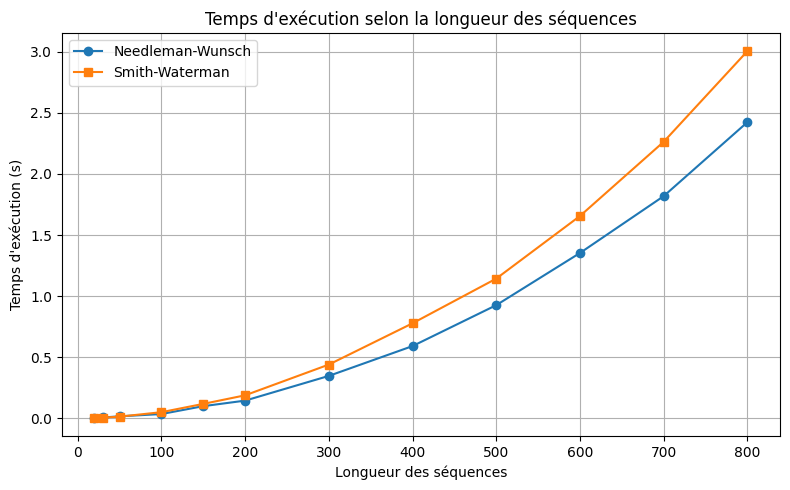

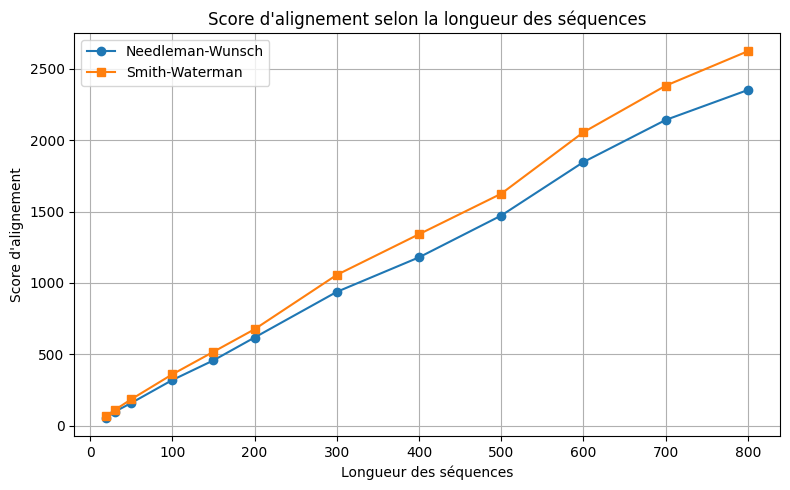

In [20]:
import csv
import matplotlib.pyplot as plt

# Lire les données depuis le fichier CSV
def read_results(filename):
    nw_lengths, nw_scores, nw_times = [], [], []
    sw_lengths, sw_scores, sw_times = [], [], []

    with open(filename, newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            algo = row["Algorithme"]
            length = int(row["Longueur"])
            score = float(row["Score"])
            time = float(row["Temps (s)"])

            if algo == "Needleman-Wunsch":
                nw_lengths.append(length)
                nw_scores.append(score)
                nw_times.append(time)
            elif algo == "Smith-Waterman":
                sw_lengths.append(length)
                sw_scores.append(score)
                sw_times.append(time)

    return (nw_lengths, nw_scores, nw_times), (sw_lengths, sw_scores, sw_times)

def plot_results(file):
    (nw_l, nw_s, nw_t), (sw_l, sw_s, sw_t) = read_results(file)

    # Temps d'exécution
    plt.figure(figsize=(8, 5))
    plt.plot(nw_l, nw_t, label='Needleman-Wunsch', marker='o')
    plt.plot(sw_l, sw_t, label='Smith-Waterman', marker='s')
    plt.xlabel('Longueur des séquences')
    plt.ylabel('Temps d\'exécution (s)')
    plt.title('Temps d\'exécution selon la longueur des séquences')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('execution_time.png')
    plt.show()

    # Score d'alignement
    plt.figure(figsize=(8, 5))
    plt.plot(nw_l, nw_s, label='Needleman-Wunsch', marker='o')
    plt.plot(sw_l, sw_s, label='Smith-Waterman', marker='s')
    plt.xlabel('Longueur des séquences')
    plt.ylabel('Score d\'alignement')
    plt.title('Score d\'alignement selon la longueur des séquences')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('alignment_score.png')
    plt.show()

if __name__ == "__main__":
    plot_results("results.csv")


# Alignement multiple

In [21]:
GAP_PENALTY = -2  # Pénalité pour gap

def nw_align(seq1, seq2):
    """
    Implémentation de l'algorithme de Needleman-Wunsch
    pour alignement global de deux séquences.
    Retourne le score et les deux séquences alignées.
    """
    m, n = len(seq1), len(seq2)
    dp = np.zeros((m+1,n+1), dtype=int)
    
    # Initialisation des bords avec pénalités gap
    for i in range(1,m+1):
        dp[i][0] = dp[i-1][0] + GAP_PENALTY
    for j in range(1,n+1):
        dp[0][j] = dp[0][j-1] + GAP_PENALTY
    
    # Remplissage de la matrice de score
    for i in range(1,m+1):
        for j in range(1,n+1):
            match = dp[i-1][j-1] + BLOSUM62.get((seq1[i-1], seq2[j-1]), -1)
            delete = dp[i-1][j] + GAP_PENALTY
            insert = dp[i][j-1] + GAP_PENALTY
            dp[i][j] = max(match, delete, insert)
    
    # Backtracking pour récupérer l'alignement
    aligned1, aligned2 = [], []
    i, j = m, n
    while i > 0 or j > 0:
        current = dp[i][j]
        if i > 0 and j > 0 and current == dp[i-1][j-1] + BLOSUM62.get((seq1[i-1], seq2[j-1]), -1):
            aligned1.append(seq1[i-1])
            aligned2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif i > 0 and current == dp[i-1][j] + GAP_PENALTY:
            aligned1.append(seq1[i-1])
            aligned2.append('-')
            i -= 1
        else:
            aligned1.append('-')
            aligned2.append(seq2[j-1])
            j -= 1
    
    # Retourner l'alignement dans le bon sens
    return dp[m][n], ''.join(reversed(aligned1)), ''.join(reversed(aligned2))


def profile_from_alignment(alignments):
    """
    Convertir une liste d'alignements (séquences alignées)
    en profil de fréquence par colonne.
    Chaque profil est une liste de dictionnaires {caractère: fréquence}.
    """
    length = len(alignments[0])
    profile = []
    chars = ['A','C','G','T','-']
    
    for i in range(length):
        col = [seq[i] for seq in alignments]
        freqs = {c: col.count(c)/len(col) for c in chars}
        profile.append(freqs)
    return profile


def score_profile_vs_char(profile_col, char):
    """
    Calculer le score d'une colonne de profil (fréquences)
    face à un caractère (nucléotide ou gap),
    en utilisant BLOSUM62 et pénalité gap.
    """
    score = 0
    for c, freq in profile_col.items():
        if c == '-':
            # Score gap vs nucléotide ou gap
            s = 0 if char == '-' else GAP_PENALTY
        else:
            # Score nucléotide vs nucléotide ou gap
            s = BLOSUM62.get((c,char), -1) if char != '-' else GAP_PENALTY
        score += freq * s
    return score


def align_profile_seq(profile, seq):
    """
    Aligner un profil (profil de fréquence) avec une séquence simple
    en utilisant une approche dynamique.
    Retourne le profil aligné et la séquence alignée.
    """
    m, n = len(profile), len(seq)
    dp = np.zeros((m+1,n+1))
    
    # Initialisation des bords
    for i in range(1,m+1):
        dp[i][0] = dp[i-1][0] + score_profile_vs_char(profile[i-1], '-')
    for j in range(1,n+1):
        dp[0][j] = dp[0][j-1] + score_profile_vs_char({'-':1}, seq[j-1])
    
    # Remplissage matrice dynamique
    for i in range(1,m+1):
        for j in range(1,n+1):
            match = dp[i-1][j-1] + score_profile_vs_char(profile[i-1], seq[j-1])
            delete = dp[i-1][j] + score_profile_vs_char(profile[i-1], '-')
            insert = dp[i][j-1] + score_profile_vs_char({'-':1}, seq[j-1])
            dp[i][j] = max(match, delete, insert)
    
    # Backtracking pour récupérer l'alignement
    aligned_profile = []
    aligned_seq = []
    i, j = m, n
    while i > 0 or j > 0:
        current = dp[i][j]
        if i > 0 and j > 0 and np.isclose(current, dp[i-1][j-1] + score_profile_vs_char(profile[i-1], seq[j-1])):
            aligned_profile.append(profile[i-1])
            aligned_seq.append(seq[j-1])
            i -= 1
            j -= 1
        elif i > 0 and np.isclose(current, dp[i-1][j] + score_profile_vs_char(profile[i-1], '-')):
            aligned_profile.append(profile[i-1])
            aligned_seq.append('-')
            i -= 1
        else:
            aligned_profile.append({'-':1})
            aligned_seq.append(seq[j-1])
            j -= 1
    
    # Remettre dans le bon sens
    aligned_profile.reverse()
    aligned_seq.reverse()
    return aligned_profile, aligned_seq


def merge_profile_seq(aligned_profile, aligned_seq):
    """
    Fusionner un profil aligné et une séquence alignée en un nouveau profil.
    Met à jour les fréquences des nucléotides / gaps.
    """
    new_profile = []
    chars = ['A','C','G','T','-']
    for col, c in zip(aligned_profile, aligned_seq):
        new_col = {}
        for ch in chars:
            freq = col.get(ch, 0) if isinstance(col, dict) else 0
            # Ajouter 1 si le caractère courant correspond au nucléotide testé
            if ch == c:
                freq += 1
            new_col[ch] = freq
        # Normaliser la fréquence
        total = sum(new_col.values())
        new_col = {ch: new_col[ch]/total for ch in chars}
        new_profile.append(new_col)
    return new_profile


def profile_to_alignment(profile):
    """
    Convertir un profil (liste de fréquences) en une séquence consensus
    en prenant le nucléotide à la fréquence maximale par colonne.
    """
    alignment = []
    for col in profile:
        max_char = max(col, key=col.get)
        alignment.append(max_char)
    return ''.join(alignment)


def progressive_alignment(sequences):
    """
    Alignement multiple progressif simple :
    - transformer chaque séquence en profil
    - fusionner itérativement les profils par paires
    """
    # Création d'un profil par séquence initiale
    profiles = [profile_from_alignment([seq]) for seq in sequences]
    
    # Fusion progressive
    while len(profiles) > 1:
        p1 = profiles.pop(0)
        p2 = profiles.pop(0)
        
        # Extraire la séquence consensus du deuxième profil
        seq2 = profile_to_alignment(p2)
        
        # Aligner le profil 1 avec la séquence 2
        aligned_profile, aligned_seq = align_profile_seq(p1, seq2)
        
        # Fusionner les deux alignements en un nouveau profil
        new_profile = merge_profile_seq(aligned_profile, aligned_seq)
        
        # Réinsertion du profil fusionné pour la prochaine itération
        profiles.insert(0, new_profile)
    
    # Retourner le profil final qui correspond à l'alignement multiple
    return profiles[0]


# Exemple d'utilisation
seqs = [
    "ACGTACGTACGT",
    "ACGTCGTTACGT",
    "ACGTCGTTGCGT"
]

msa_profile = progressive_alignment(seqs)

print("Alignement consensus :", profile_to_alignment(msa_profile))


Alignement consensus : ACGT-CGTTACGT


In [6]:
# Fonction pour calculer le score d'alignement global entre deux séquences
def score_seq_vs_seq(seq1, seq2):
    """
    Calcule le score d'alignement global entre seq1 et seq2
    en utilisant la méthode Needleman-Wunsch avec GAP_PENALTY et BLOSUM62.
    Retourne uniquement le score final (pas l'alignement).
    """
    m, n = len(seq1), len(seq2)
    dp = np.zeros((m+1, n+1), dtype=int)
    
    # Initialisation des bords avec pénalités gap
    for i in range(1, m+1):
        dp[i][0] = dp[i-1][0] + GAP_PENALTY
    for j in range(1, n+1):
        dp[0][j] = dp[0][j-1] + GAP_PENALTY
    
    # Remplissage de la matrice de score
    for i in range(1, m+1):
        for j in range(1, n+1):
            match = dp[i-1][j-1] + BLOSUM62.get((seq1[i-1], seq2[j-1]), -1)
            delete = dp[i-1][j] + GAP_PENALTY
            insert = dp[i][j-1] + GAP_PENALTY
            dp[i][j] = max(match, delete, insert)
    
    # Score final dans la cellule en bas à droite
    return dp[m][n]

# Fonction pour tester l'alignement multiple sur plusieurs tailles d'entrée
def test_multiple_alignments(seqs_list):
    """
    Pour chaque liste de séquences dans seqs_list :
    - effectue un alignement multiple progressif,
    - mesure le temps d'exécution,
    - calcule le score moyen d'alignement du consensus contre chaque séquence.
    
    Retourne une liste de dictionnaires avec les résultats.
    """
    results = []
    for seqs in seqs_list:
        start = time.time()  # Début du chronomètre
        msa_profile = progressive_alignment(seqs)  # Alignement multiple
        end = time.time()    # Fin du chronomètre
        
        consensus = profile_to_alignment(msa_profile)  # Récupérer la séquence consensus
        
        # Calculer le score d'alignement consensus vs chaque séquence
        scores = [score_seq_vs_seq(consensus, s) for s in seqs]
        avg_score = sum(scores) / len(scores)  # Score moyen
        
        results.append({
            "num_seqs": len(seqs),    # Nombre de séquences alignées
            "time": end - start,      # Durée d'exécution en secondes
            "avg_score": avg_score,   # Score moyen d'alignement
            "consensus": consensus    # Séquence consensus finale
        })
    return results

# Exemple de jeu de séquences de base (10 séquences)
base_seqs = [
    "ACGTACGTACGT",
    "ACGTCGTTACGT",
    "ACGTCGTTGCGT",
    "ACGTACGTGCGT",
    "ACGTCGTCACGT",
    "ACGTAGGTACGT",
    "ACGTAGGTGCGT",
    "ACGTTGGTGCGT",
    "ACGTAGGTACGT",
    "ACGTCGGTACGT"
]

# Crée des sous-listes de séquences de taille 3 à 10
seqs_list = [base_seqs[:i] for i in range(3, 11)]

# Lancer les tests sur chaque taille de liste
results = test_multiple_alignments(seqs_list)

# Afficher les résultats pour chaque test
for r in results:
    print(f"Séquences: {r['num_seqs']:2d}, Temps: {r['time']:.4f}s, Score moyen vs consensus: {r['avg_score']:.2f}")


Séquences:  3, Temps: 0.0023s, Score moyen vs consensus: 67.67
Séquences:  4, Temps: 0.0024s, Score moyen vs consensus: 66.50
Séquences:  5, Temps: 0.0033s, Score moyen vs consensus: 63.40
Séquences:  6, Temps: 0.0037s, Score moyen vs consensus: 55.17
Séquences:  7, Temps: 0.0048s, Score moyen vs consensus: 56.29
Séquences:  8, Temps: 0.0052s, Score moyen vs consensus: 55.62
Séquences:  9, Temps: 0.0074s, Score moyen vs consensus: 57.11
Séquences: 10, Temps: 0.0070s, Score moyen vs consensus: 61.20


In [13]:
def generate_random_dna_sequences(num_seqs, length):
    """Generate a list of random DNA sequences."""
    return [''.join(random.choice('ACGT') for _ in range(length)) for _ in range(num_seqs)]

def test_alignment_for_lengths(seq_count, lengths):
    """
    For a fixed number of sequences (seq_count), test progressive alignment on 
    increasing sequence lengths (list lengths).
    Return a list of dicts with length, execution time, and average score.
    """
    results = []

    for L in lengths:
        # Generate random sequences
        seqs = generate_random_dna_sequences(seq_count, L)
        
        start_time = time.time()
        msa_profile = progressive_alignment(seqs)
        exec_time = time.time() - start_time
        
        consensus = profile_to_alignment(msa_profile)
        
        # Calculate average alignment score vs consensus
        total_score = 0
        for seq in seqs:
            score, _, _ = nw_align(seq, consensus)
            total_score += score
        avg_score = total_score / seq_count
        
        results.append({
            'length': L,
            'time': exec_time,
            'avg_score': avg_score
        })
        
        print(f"Length: {L}, Time: {exec_time:.4f}s, Avg score: {avg_score:.2f}")

    return results

# Example parameters
num_sequences = 5  # fixed number of sequences
sequence_lengths = [100, 150, 200, 300, 500, 600]  # sequence lengths to test

results = test_alignment_for_lengths(num_sequences, sequence_lengths)

Length: 100, Time: 0.2154s, Avg score: 293.40
Length: 150, Time: 0.4357s, Avg score: 410.20
Length: 200, Time: 0.6529s, Avg score: 611.80
Length: 300, Time: 1.3983s, Avg score: 922.00
Length: 500, Time: 3.8901s, Avg score: 1579.60
Length: 600, Time: 6.0362s, Avg score: 1809.60
